# Optimización de Portafolios con Restricciones según la Teoría de Markowitz

En 1952, Markowitz proponia lo que se conoce como toería de portafolios, cuyo modelo fue utilizado extensivamente en el mundo de las finanzas, sin embargo, recientemente se encontró que en la práctica las soluciones encontradas por el modelo no funcionaban como se esperaba. Esto se debía a diversos factores, pero uno de los más significativos era la falta de estabilidad en las soluciones, pues la mayoría de los métodos para obtener las soluciones (ya sea mediante caminos analíticos o numéricos) requerían de la inversión de la matriz de varianza covarianza muestral, y **pequeños errores de estimación en la matriz de varianza covarianza se magnificaban de forma importante al realizar la inversión de la matriz de dicha matriz**, lo que alteraba significativamente las soluciones obtenidas mediante el modelo de Markowitz. 

Una de las soluciones a este inconveniente fue la adición de restricciones al planteamineto original, lo que estabilizaba la solución y también dotaba de cierta flexibilidad al modelo, pues las restricciones permitian reflejar de forma más precisa el mundo real.

## Librerías externas y descarga de la información

A continuación se descargan librerías auxiliares para la optimizacioń, procesamiento y descarga de los datos, así como para la estimación de la matriz de varianza covarianza.

In [1]:
from math import sqrt
from cvxopt import matrix
from cvxopt import solvers
from cvxopt.blas import dot
from cvxopt.solvers import qp
import pylab
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.pyplot import figure
import pandas as pd
import scipy.stats as sp 
import itertools
import seaborn as sns

Es posible configurar el solver para no mostrar el progreso de la búsqueda de la solución óptima

In [2]:
solvers.options['show_progress'] = False

## Implementación con un número pequeño de activos

Para poder interpretar las soluciones de forma más sencilla, primero se utilizarán únicamente cuatro activos:

- Bitcoin
- Oro
- Peso/Dólar
- Índice de Precios y Cotizaciones (IPC)

La información de estos activos pueden ser obtenidos de Yahoo Finance, y se utilizará información de todo el año 2021. 

In [3]:
selected_stocks = ['BTC-USD','GC=F', 'MXN=X','^MXX']
raw = yf.download(selected_stocks,"2021-01-01","2021-12-31") 

[*********************100%***********************]  4 of 4 completed


Para poder hacer la estimación de la matriz de varianza covarianza, es necesario que no se tengan valores faltantes, por lo que a continuación se quitan valores nulos y se obtienen los retornos diarios de los activos seleccionados. Estos retornos se pueden guardar en un csv para poder replicar posteriormente este mismo ejercicio si así se quisiera.

In [4]:
precios_cierre = pd.DataFrame(raw.Close).dropna()
retpor = precios_cierre.pct_change(periods=1).iloc[1:,:]
retpor.to_csv('./retpor.csv', index = True)

In [5]:
retpor.head(10)

,BTC-USD,GC=F,MXN=X,^MXX
Date,,,,
2021-01-05,0.063197,0.004114,0.004784,0.004589
2021-01-06,0.083311,-0.023455,-0.002018,0.015121
2021-01-07,0.069157,0.002832,-0.012382,0.013195
2021-01-08,0.036234,-0.040893,0.017518,0.011705
2021-01-11,-0.128217,0.008451,0.002519,-0.007147
2021-01-12,-0.046215,-0.003622,0.000594,-0.009560
2021-01-13,0.100032,0.005806,-0.013357,-0.004605
2021-01-14,0.050138,-0.001780,0.002118,0.007231
2021-01-15,-0.060274,-0.011350,-0.005697,-0.003877


Se muestra una gráfica de la matriz de correlación muestral, para mostrar que la mayoría de los activos utilizados no están particularmente correlacionados. Puede notarse que la mayoría de las correlaciones están cercanas al cero (pues son de color rojo).

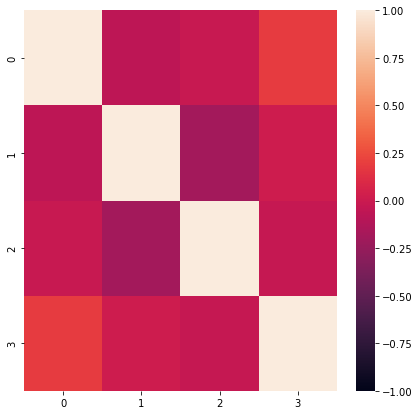

In [6]:
cov_m = np.corrcoef(retpor.T)
fig = plt.figure(figsize = (7, 7))
ax = sns.heatmap(cov_m, vmin=-1, vmax=1)

A continuación se irán aplicando una a una las restricciones que se han analizado, se obtendrá la frontera óptima y se comentará sobre las soluciones obtenidas. En cada ocación se utilizará la matriz de varianza covarianza muestral $E$ como estimador de $\Sigma$ y se usarán el promedio de los retornos como estimador de $\mu$. Hay que notar que hay formas mucho más precisas y complejas de estimar estos dos parámetros, sin embargo, para no perder el objetivo de este notebook (que es centrarse en las restricciones), se usarán estos estimadores al ser más simples y ampliamente conocidos.

# Restricción de Ganancia Mínima (solución analítica)

Bajo esta restricción, se constriñe al modelo la búsqueda de portafolios cuya ganancia esperada sea al menos de $G$.

La función objetivo es la siguiente:

$$ \underset{w \in \mathbb{R}^p}{\text{min}} \frac{1}{2}  w^t \Sigma w$$

La restricción se expresa de la siguiente forma:

$$ w^t g \geq G$$

Para este planteamiento existe una solución analítica, la cuál está dada por:

$$ x^* = \frac{G E^{-1} \mu}{\mu^T E^{-1} \mu}$$

In [19]:
E = np.cov(retpor.T)
g = np.mean(retpor, axis = 0)

In [113]:
E

array([[ 2.47681790e-03, -3.05958467e-05, -5.45297299e-06,
         7.96447410e-05],
       [-3.05958467e-05,  8.75502741e-05, -1.19931407e-05,
         1.06575493e-06],
       [-5.45297299e-06, -1.19931407e-05,  4.61111288e-05,
        -1.59860240e-06],
       [ 7.96447410e-05,  1.06575493e-06, -1.59860240e-06,
         7.67955766e-05]])

In [114]:
g

BTC-USD    0.002823
GC=F      -0.000243
MXN=X      0.000166
^MXX       0.000747
dtype: float64

Procedemos a definir la función que nos permite obtener la solución analítica, siendo que el único parámetro es el valor de $G$, es decir, de la ganancia mínima esperada del portafolio.

In [11]:
def pesos_ganancia_minima(ganancia):
  return ganancia * ((np.linalg.inv(E)@g)/(g.T @ np.linalg.inv(E)@g))

A continuación calculamos la solución para varios valores de $G$ y cuantificamos la varianza asociado a cada portafolio mediante la formula:

$$ \sigma^2 = x^T \Sigma x $$

Los resultados los guardamos en un dataframe 

In [115]:
prueba1 = pesos_ganancia_minima(.004749)
print(prueba1)
print(g@prueba1)

[ 0.39011872 -0.99216962  1.62506982  4.19897583]
0.004749


A continuación se muestra la frontera óptima. Hay algo que salta inmediatamente a la vista y es que el riesgo aumenta de forma proporcional a la ganancia sin parecer acercarse a un límite asintótico (es decir, a una ganancia máxima). Esto se debe a que no se están utilizando restricciones posteriores para poder constriñir las soluciones obtenidas analíticamente, como se mostrará más adelante:

In [116]:
prueba2 = pesos_ganancia_minima(.015)
print(prueba2)
print(g@prueba2)

[ 1.23221326 -3.13382698  5.13288004 13.26271581]
0.015


Inspeccionemos a continuación un ejemplo. Digamos que $G = 0.004749$, es decir, que deseamos obtener el portafolio cuya ganancia esperada (o rendimiento) mínima sea de $0.4749 \%$. La solución obtenida sería entonces la siguiente:

In [22]:
pesos_ganancia_minima(.004749)

array([ 0.39011872, -0.99216962,  1.62506982,  4.19897583])

Salta a la vista que se tienen pesos que son negativos, e incluso algunos que son mayores a 1. En este caso entra el concepto de ventas en corto y de apalancamiento, pues básicamente podemos interpretar la solución obtenida de la siguiente forma: para el primer activo (BTC) hay que invertir el 39% del capital, para el segundo activo (Oro) hay que pedir prestado  el equivalente al 99.21% de nuestro capital, venderlo inmediatamente y comprarlo a un precio más bajo en el futuro. Para los dólares, habría que apalancar nuestra posición en un equivalente al 1.6 veces de nuestro capital e invertirlo en dólares y, por último, habría que apalancarse en el IPC 4.16 veces el equivalente a nuestro capital!. Estas soluciones no son muy realistas, sin embargo, hablando matemáticamente, son correctas, pues puede observarse a continuación que la ganancía mínima es justo la esperada, y además al formar parte de la frontera eficiente esta asignación de capital es la que tiene un menor riesgo. 

In [23]:
pesos_ganancia_minima(.004749) @ g

0.004749

# Restricción de asignación o uso de todo el capital

Esta restricción consiste en constriñir el conjunto solución a portafolios que impliquen la asingación de todo el capital disponible. La función objetivo es la siguiente

$$x*(\phi) = \text{min}\frac{1}{2} x^T \Sigma x - \frac{1}{\phi} \mu^Tx $$

y la restricción puede expresarse como

$$ \sum_{i=1}^n x_i = 1 $$

o lo que es equivalente en notación matricial

$$ \boldsymbol{1}^T \mu = 1$$

Para obtener la solución utilizando esta restricción, es necesario utilizar un optimizador, pues hay que observar que las restricciones son lineales, lo que se presta a utilizar programación cuadrática. En este notebook usaremos el paquete CVXOPT para poder obtener las soluciones. Primero es necesario convertir $E$ y $g$ en matrices que puedan ser utilizadas en el optimizador:

In [25]:
E_matriz = matrix(E)
g_matriz = matrix(g)

Obtenemos algunos parámetros necesarios:

In [21]:
n = len(g)

Y pasamos la restricción $ \boldsymbol{1}^T \mu = 1$ a la forma $A x = b$ para tener el planteamiento en la forma general de un problema de programación cuadrática:

In [22]:
A = matrix(1.0, (1,n))
b = matrix(1.0)

También es necesario definir distintos valores del parámetro $\phi$, recordando que a mayor este valor, menor será la aversión al riesgo del inversionista. Como queremos obtener la frontera óptima, es decir, inspeccionar el mejor portafolio para distintos niveles de riesgo, vamos a obtener la solución para distintas aversiones al riesgo (i.e. distintos valores de $\phi$). Vamos a obtener entonces 100 valores de phi que van desde 0.1 (mucha aversión al riesgo) hasta 8900 (muy poca aversión al riesgo)

In [29]:
N = 2000
phis = [ 10**(5.0*t/N-1.0) for t in range(10000) ]

In [23]:
phis = np.linspace(0.1, 20000, 5)

In [30]:
np.max(phis)

9.942600739529537e+23

Ahora sí estamos en condiciones de meter los parámetros al optimizador y poder obtener la solución ($x*$) para cada valor de $\phi$

In [31]:
portfolios = [ qp(P = phi*E_matriz, q = -g_matriz,A= A, b =b)['x'] for phi in phis ]

Cada uno de los elementos de la lista es la solución óptima para cada valor de $\phi$, y es posible entonces cuantificar la ganancia $G$ y la varianza de dicha ganancia (o el cuadrado del riesgo del portafolio) $R^2$ para cada una de las soluciones obtenidas y entonces sí proceder a calcular la frontera óptima: 

In [32]:
returns = [ dot(g_matriz,x) for x in portfolios ]
risks = [ sqrt(dot(x, E_matriz*x)) for x in portfolios ]

Por último, es posible convertir estas listas a formato de numpy y hacer un data frame con los resultados, que es lo que hacemos a continuación:

In [33]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_todo_capital = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [36]:
np.max(returns_df)

0.07870000395157695

Podemos mostrar algunos de los resultados en el dataframe, donde es posible observar que se tiene la ganancia, el riesgo cuadrado y el valor de $\phi$ para los distintos portafolios de la frontera óptima:

In [34]:
rest_todo_capital.head(10)

,riesgo,retorno,phi
0,0.885983,0.078700,0.100000
1,0.880897,0.078249,0.100577
2,0.875841,0.077801,0.101158
3,0.870814,0.077356,0.101742
4,0.865816,0.076913,0.102329
5,0.860846,0.076473,0.102920
6,0.855905,0.076035,0.103514
7,0.850992,0.075600,0.104112
8,0.846108,0.075167,0.104713
9,0.841252,0.074737,0.105317


Ahora sí podemos graficar la frontera óptima:

Text(0, 0.5, 'Retorno %')

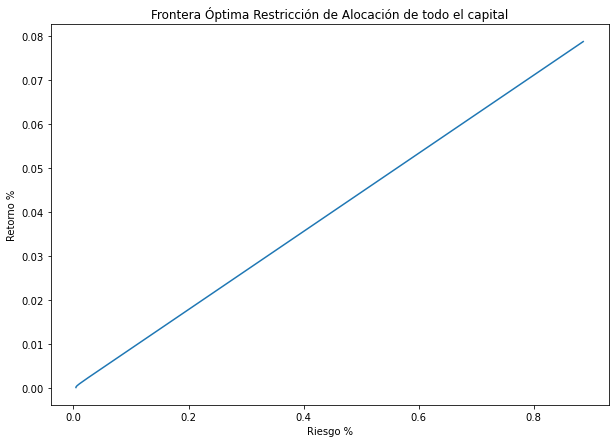

In [35]:
ax = rest_todo_capital.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción de Alocación de todo el capital", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

Podemos observar que una vez más, si únicamente se utiliza esta restricción, el riesgo aumenta de forma proporcional a la ganancia sin que se vea un acercamiento a un valor asintótico. Esto se debe a que, aunque todas las soluciones cumplen con la restricción de asignación de todo el capital, aún se hace uso del apalancamiento y de las ventas en corto, lo que permite obtener virtualmente cualquier nivel de ganancia. 

Para verificar que las soluciones cumplen con la restricción establecida, inspeccionemos una de ella:

In [46]:
np.array(portfolios[10])

array([[  2.49280125],
       [-16.10140173],
       [ -5.45838155],
       [ 20.06698203]])

Podemos observar de nuevo la presencia de pesos mayores a 1 y negativos, sin embargo, si sumamos los pesos, obtenemos 1, justo como lo especificamos en la restricción.

In [47]:
np.array(portfolios[10]).sum()

1.0000000000000142

In [20]:
risks_df = np.array(riesgo_ganancia_minima)
returns_df = np.array(retornos_ganancia_minima)
rest_todo_capital = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df})

Notar que conforme disminuye el riesgo, también disminuyen los retornos y aumenta el valor de $\phi$.

In [13]:
rest_todo_capital.tail()

,riesgo,retorno,phi
95,0.004454,0.000189,5623.413252
96,0.004454,0.000189,6309.573445
97,0.004454,0.000188,7079.457844
98,0.004454,0.000188,7943.282347
99,0.004454,0.000188,8912.509381


### Portafolio con Mayor Riesgo y Mayor Rendimiento

A continuación se analiza el portafolio de mayor riesgo. La composición del portafolio en este caso sería la siguiente, observando que se utiliza fuertemente las ventas en corto y el apalancamiento, además de que la mayor posición larga es en el índice de precios y cotizaciones y la posición corta más fuerte es en el oro:

In [38]:
(np.round(portfolios[0], decimals = 3))

array([[  7.874],
       [-51.511],
       [-18.298],
       [ 62.935]])

El nivel de riesgo particular para este portafolio sería:

In [39]:
rest_todo_capital.iloc[0]

riesgo     0.885983
retorno    0.078700
phi        0.100000
Name: 0, dtype: float64

Constatamos manualmente que en efecto la ganancia del portafolio sea la que se guardó en el dataframe

In [41]:
g@ np.array(portfolios[0]) 

array([0.0787])

Ahora se analiza la restricción del portafolio con menor riesgo. Se puede observar que en este caso el riesgo es prácticamente 0, pero también el rendimiento es de prácticamente 0. Es posible observar también que la mayor posición larga en este caso es en la paridad peso dólar y la menor posición larga es en el Bitcoin. 

In [42]:
rest_todo_capital.iloc[-1]

riesgo     4.291318e-03
retorno    2.052897e-04
phi        9.942601e+23
Name: 9999, dtype: float64

In [44]:
np.round(portfolios[-1], decimals = 3)

array([[0.004],
       [0.275],
       [0.48 ],
       [0.242]])

In [45]:
g@ np.array(portfolios[-1]) 

array([0.00020529])

# Restricción de No Ventas en Corto


Esta restricción consiste en no permitir ventas en corto, es decir, que no existan pesos con magnitud negativa en las soluciones obtenidas. Esta restricción se implementa mediante una restricción lineal en la que se fuerza a que todos los pesos de la solución deben ser 0 o positivos

In [53]:
# Problem data.
n = len(g)

# Restriccioń de no ventas en corto
# G es la matriz identidad y tiene que ver con la restricción x >= 0 (parte derecha G x)
G = matrix(0.0, (n,n))
G[::n+1] = -1.0
# h es un vector de ceros y es el lado derecho de la restriccioń x >= 0
h = matrix(0.0, (n,1))

# Definición de número de valores de phi que se van a calcular.
N = 2000
# mu es el riesgo que se está dispuesto a tomar (mientras más bajo sea, más riesgo se está dispuesto a tomar)
# un valor de este mu de 0 indica que no importa el riesgo, solo se busca el mayor valor esperado
# un valor de mu que sea muy grande indica que no se quiere tomar riesgo. 
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(phi*E_matriz, -g_matriz, G = G, h = h)['x'] for phi in phis ]

returns = [ dot(g_matriz,x) for x in portfolios ]
risks = [ sqrt(dot(x, E_matriz*x)) for x in portfolios ]


In [54]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_ventas_corto = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

A continuación es posible ver los riesgos y rendimientos de los portafolios más y menos riesgosos

In [55]:
rest_ventas_corto.head()

,riesgo,retorno,phi
0,0.987990,0.097612,0.100000
1,0.982319,0.097052,0.100577
2,0.976681,0.096495,0.101158
3,0.971075,0.095941,0.101742
4,0.965501,0.095391,0.102329


In [56]:
rest_ventas_corto.tail()

,riesgo,retorno,phi
1995,0.00001,1.011421e-06,9716.279516
1996,0.00001,1.005729e-06,9772.372210
1997,0.00001,1.000070e-06,9828.788730
1998,0.00001,9.944438e-07,9885.530947
1999,0.00001,9.888506e-07,9942.600740


Text(0, 0.5, 'Retorno %')

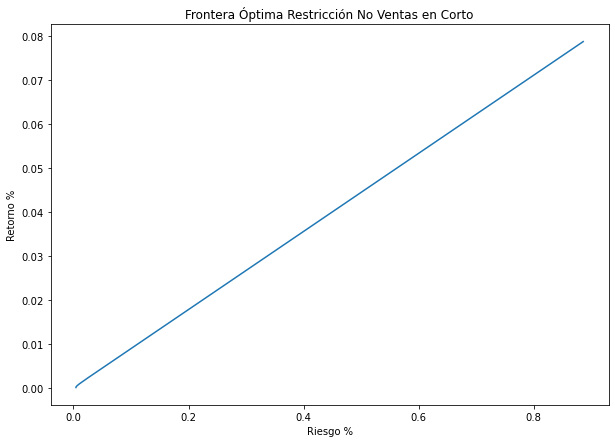

In [57]:
ax = rest_todo_capital.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción No Ventas en Corto", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

Se procede a analizar el portafolio con más retorno, notándo que la mayor posición larga se tiene en el IPC

In [60]:
np.round(portfolios[0], decimals = 3)

array([[ 8.617],
       [ 0.   ],
       [40.218],
       [89.159]])

In [61]:
rest_ventas_corto.iloc[0]

riesgo     0.987990
retorno    0.097612
phi        0.100000
Name: 0, dtype: float64

In [62]:
g@ np.array(portfolios[0]) 

array([0.09761247])

Se analiza a continuación el portafolio de menor retorno. notándo que al no restringir la solución para que se inverta el capital y al notar que todos los activos en el portafolio tienen un nivel de riesgo, la solución entonces es no invertir.

In [64]:
rest_ventas_corto.iloc[-1]

riesgo     1.023487e-05
retorno    9.888506e-07
phi        9.942601e+03
Name: 1999, dtype: float64

Notar que el retorno es mucho más bajo debido a que se quitó la restriccioń de tener que utilizar todo el capital

In [65]:
np.round(portfolios[-1], decimals = 3)

array([[0.   ],
       [0.   ],
       [0.001],
       [0.001]])

In [66]:
g@ np.array(portfolios[-1]) 

array([9.88850569e-07])

# Restricción de No Apalancamiento

Esta restricción se implementa de forma indirecta, pues implementar la restricción de alocación de todo el capital más la restricción de no ventas en corto equivale a implementar la restricción de no apalancamiento

In [32]:
# Problem data.
n = len(g)
# Restriccioń de no ventas en corto
# G es la matriz identidad y tiene que ver con la restricción x >= 0 (parte derecha G x)
G = matrix(0.0, (n,n))
G[::n+1] = -1.0
# h es un vector de ceros y es el lado derecho de la restriccioń x >= 0
h = matrix(0.0, (n,1))

## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)
A = matrix(1.0, (1,n))
# es escalar 1 que es la parte derecha de 1T x = 1
b = matrix(1.0)

# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(phi*S, -pbar, G, h, A, b)['x'] for phi in phis ]


returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]

In [33]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_apalancamiento = pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [34]:
rest_apalancamiento.head()

,riesgo,retorno,phi
0,0.052019,0.004749,0.100000
1,0.052019,0.004749,0.112202
2,0.052019,0.004749,0.125893
3,0.052019,0.004749,0.141254
4,0.052019,0.004749,0.158489


In [35]:
rest_apalancamiento.tail()

,riesgo,retorno,phi
95,0.004454,0.000189,5623.413252
96,0.004454,0.000189,6309.573445
97,0.004454,0.000188,7079.457844
98,0.004454,0.000188,7943.282347
99,0.004454,0.000188,8912.509381


Text(0, 0.5, 'Retorno %')

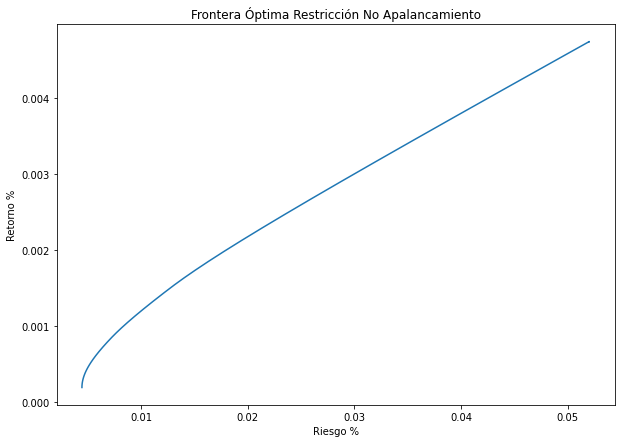

In [36]:
ax = rest_apalancamiento.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción No Apalancamiento", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [37]:
np.round(portfolios[0], decimals = 3)

array([[1.],
       [0.],
       [0.],
       [0.]])

In [38]:
rest_apalancamiento.iloc[0]

riesgo     0.052019
retorno    0.004749
phi        0.100000
Name: 0, dtype: float64

In [39]:
g@ np.array(portfolios[0]) 

array([0.00474932])

In [40]:
rest_apalancamiento.iloc[-1]

riesgo        0.004454
retorno       0.000188
phi        8912.509381
Name: 99, dtype: float64

In [41]:
np.round(portfolios[-1], decimals = 3)

array([[0.008],
       [0.269],
       [0.486],
       [0.236]])

In [42]:
g@ np.array(portfolios[-1]) 

array([0.00018806])

# Restricción de activo libre de riesgo

Notar que para poder aplicar la solución analítica, se está estableciendo de forma implicita la restricción de alocación de todo el capital.  

In [43]:

S_con_riesgo = matrix(
    [[ 0.002706, -0.000033, -1.916605e-05	,6.999402e-05, 0],
    [ -0.000033	, 0.000091, -1.038888e-05	,2.299984e-06, 0],
    [-0.000019	, -0.000010	, 4.653256e-05	,5.655895e-07, 0],
    [ 0.000070,0.000002	,5.655895e-07	,7.788368e-05, 0],
     [ 0,0,0	,0, 0]])


# rendimiento del activo libre de riesgo
# se asume que la varianza del activo libre de riesgo es 0 y su covarianza con los
# otros activos también es 0
r = 0.00001

In [44]:
def pesos_activos_riesgo(phi):
  pesos_riesgo = ((1/phi) * np.linalg.inv(S) @ 
                  (pbar.T - (r *np.repeat(1,4))).T )
  peso_act_libre =1 - pesos_riesgo.sum()
  return np.append(pesos_riesgo,peso_act_libre)


In [45]:
pesos_riesgo = [ pesos_activos_riesgo(phi) for phi in phis ]

In [46]:
# verificando que la suma de los pesos es uno
pesos_riesgo[0].sum()

1.0

In [47]:
rest_libre_riesgo = np.zeros((100,3))
rest_libre_riesgo[:,2] = phis
for i in range(100):
  rend = pesos_riesgo[i] @ np.append(pbar, r)
  risk = float(np.array(pesos_riesgo[i]).reshape(5,1).T @ S_con_riesgo @ np.array(pesos_riesgo[i]).reshape(5,1)) 
  rest_libre_riesgo[i,0] = rend
  rest_libre_riesgo[i,1] = risk
rest_libre_riesgo = pd.DataFrame(data = {"riesgo":rest_libre_riesgo[:,1],"retorno": rest_libre_riesgo[:,0], "phi": rest_libre_riesgo[:,2]})

In [48]:
rest_libre_riesgo.head()

,riesgo,retorno,phi
0,1.496787,0.149689,0.100000
1,1.188940,0.133411,0.112202
2,0.944409,0.118904,0.125893
3,0.750170,0.105974,0.141254
4,0.595882,0.094451,0.158489


In [49]:
rest_libre_riesgo.tail()

,riesgo,retorno,phi
95,4.733256e-10,0.000013,5623.413252
96,3.759759e-10,0.000012,6309.573445
97,2.986482e-10,0.000012,7079.457844
98,2.372247e-10,0.000012,7943.282347
99,1.884343e-10,0.000012,8912.509381


Text(0, 0.5, 'Retorno %')

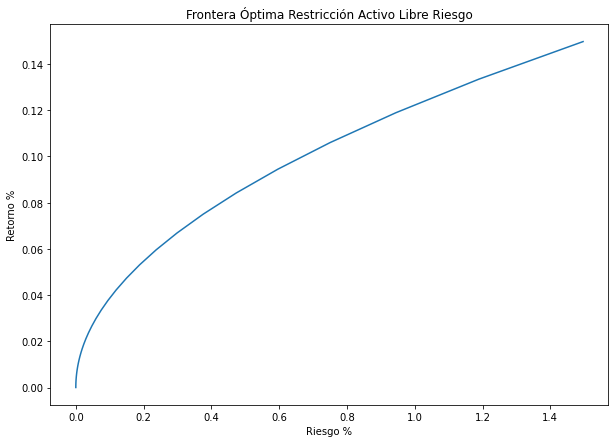

In [50]:
ax = rest_libre_riesgo.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción Activo Libre Riesgo", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [51]:
np.round(pesos_riesgo[0].reshape(5,1), decimals = 3)

array([[ 15.046],
       [-31.018],
       [ 19.287],
       [ 85.991],
       [-88.307]])

In [52]:
rest_libre_riesgo.iloc[0]

riesgo     1.496787
retorno    0.149689
phi        0.100000
Name: 0, dtype: float64

In [53]:
np.append(pbar, r) @ np.array(pesos_riesgo[0]) 

0.1496886879100926

In [54]:
np.round(pesos_riesgo[-1].reshape(5,1), decimals = 3)

array([[ 0.   ],
       [-0.   ],
       [ 0.   ],
       [ 0.001],
       [ 0.999]])

In [55]:
rest_libre_riesgo.iloc[-1]

riesgo     1.884343e-10
retorno    1.167942e-05
phi        8.912509e+03
Name: 99, dtype: float64

In [56]:
np.round(pesos_riesgo[-1], decimals = 2)

array([ 0., -0.,  0.,  0.,  1.])

In [57]:
np.append(pbar, r) @ np.array(pesos_riesgo[-1]) 

1.1679422500508281e-05

# Restricción de Intervalos de alocación

Esta restricción consiste en definir un intervalo para el peso de un determinado activo, por ejemplo si queremos restringir que el capital asignado a BTC no sea menor del 20% del capital pero tampoco mayor al 50%, entonces tenemos que:

$$0.2 \leq x_1 \leq 0.5$$

Esta es una restricción **lineal** y es posible introducirla diréctamente en la matriz de restricciones al formular el problema de programación cuadrática

In [67]:
#Creación de la matriz con intervalos
# .2 <=x1 <=.5
#  .1 <=     x4 <=.3
# notar que implicitamente se está poniendo la restricción de no venta en corto para 
# x1 y x4, y que explícitamente se pone esta restricción para x_2 y x_3
G = matrix(
    [[ 1.0, -1.0, 0.0	,0.0,0.0,0.0],
     [0,      0     , -1.0	,0,0,0],
    [ 0	, 0, 0	,-1.0,0,0],
    [0	, 0	,0	,0,1.0,-1.0]])

h = matrix([.5,
            -.2,
            0,
            0,
            .3,
            -.1])

In [69]:
# Problem data.
n = len(g)


# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]

portfolios = [ qp(phi*E_matriz, -g_matriz, G=G, h=h)['x'] for phi in phis ]

returns = [ dot(g_matriz,x) for x in portfolios ]
risks = [ sqrt(dot(x, E_matriz*x)) for x in portfolios ]


In [70]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_intervalo= pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [71]:
rest_intervalo.head()

,riesgo,retorno,phi
0,0.246512,0.007659,0.100000
1,0.220008,0.007005,0.112202
2,0.196423,0.006422,0.125893
3,0.175443,0.005903,0.141254
4,0.156791,0.005440,0.158489


In [72]:
rest_intervalo.tail()

,riesgo,retorno,phi
95,0.010125,0.000629,5623.413252
96,0.010125,0.000629,6309.573445
97,0.010125,0.000629,7079.457844
98,0.010125,0.000629,7943.282347
99,0.010125,0.000629,8912.509381


Text(0, 0.5, 'Retorno %')

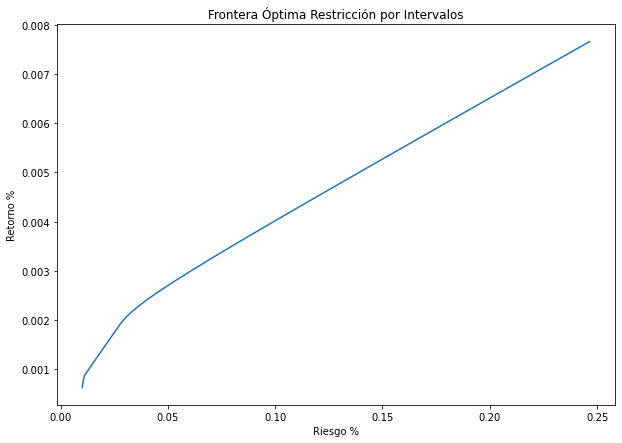

In [73]:
ax = rest_intervalo.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción por Intervalos", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [64]:
np.round(portfolios[0], decimals = 3)

array([[ 0.5  ],
       [ 0.   ],
       [23.412],
       [ 0.3  ]])

In [65]:
rest_intervalo.iloc[0]

riesgo     0.160534
retorno    0.005137
phi        0.100000
Name: 0, dtype: float64

In [66]:
g@ np.array(portfolios[0]) 

array([0.00514598])

In [67]:
rest_intervalo.iloc[-1]

riesgo        0.010532
retorno       0.001012
phi        8912.509381
Name: 99, dtype: float64

In [68]:
np.round(portfolios[-1], decimals = 3)

array([[0.2  ],
       [0.081],
       [0.099],
       [0.1  ]])

In [69]:
g@ np.array(portfolios[-1]) 

array([0.00101232])

## Añadiendo restriccion de alocación de todos los activos

In [70]:
# Problem data.
n = len(g)

## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)
A = matrix(1.0, (1,n))
# es escalar 1 que es la parte derecha de 1T x = 1
b = matrix(1.0)

# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
portfolios = [ qp(phi*S, -pbar, G, h, A, b)['x'] for phi in phis ]


returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]


In [71]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_intervalo= pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [72]:
rest_intervalo.head()

,riesgo,retorno,phi
0,0.026507,0.00263,0.100000
1,0.026507,0.00263,0.112202
2,0.026507,0.00263,0.125893
3,0.026507,0.00263,0.141254
4,0.026507,0.00263,0.158489


In [73]:
rest_intervalo.tail()

,riesgo,retorno,phi
95,0.010863,0.000988,5623.413252
96,0.010863,0.000988,6309.573445
97,0.010863,0.000988,7079.457844
98,0.010863,0.000988,7943.282347
99,0.010863,0.000988,8912.509381


Text(0, 0.5, 'Retorno %')

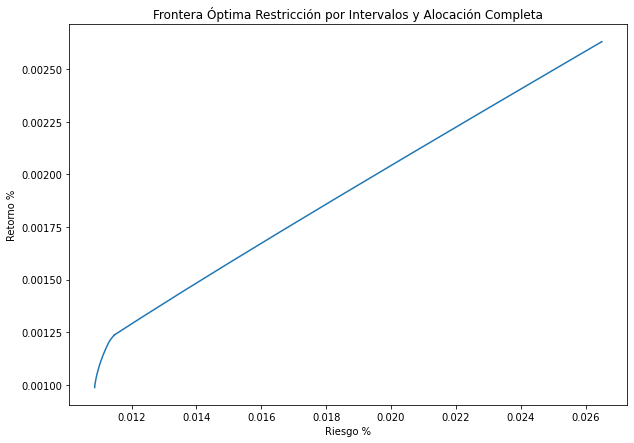

In [74]:
ax = rest_intervalo.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción por Intervalos y Alocación Completa", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [75]:
np.round(portfolios[0], decimals = 3)

array([[0.5],
       [0. ],
       [0.2],
       [0.3]])

In [76]:
rest_intervalo.iloc[0]

riesgo     0.026507
retorno    0.002630
phi        0.100000
Name: 0, dtype: float64

In [77]:
g@ np.array(portfolios[0]) 

array([0.00263006])

Notar que al forzar que se invierta todo el capital, se obtiene un portafolio con un riesgo más alto y un retorno más bajo en comparación cuando se usa también la restricción de intervalos pero sin la restricción de alocaccioń de todo el capital (ejemplo pasado).

In [78]:
rest_intervalo.iloc[-1]

riesgo        0.010863
retorno       0.000988
phi        8912.509381
Name: 99, dtype: float64

Notar que aún cuando se esperaría que la solución fuera asignar todo el capital al activo con menos riesgo, hay que notar que en la matriz de var-cov, las estructuras de correlación influyen y logran obtener un portafolio con menos riesgo ( 0.0045) considerando que el activo menos riesgoso tiene un riesgo de (0.0088)

In [79]:
np.round(portfolios[-1], decimals = 3)

array([[0.2  ],
       [0.268],
       [0.432],
       [0.1  ]])

In [80]:
retpor.std()

BTC-USD    0.052017
GC=F       0.009555
MXN=X      0.006821
^MXX       0.008825
dtype: float64

In [81]:
g@ np.array(portfolios[-1]) 

array([0.00098784])

# Restricción de Intervalos de alocación por grupos

In [82]:
#Creación de la matriz con intervalos
# .2 <=x1+x3 <=.5
#  .1 <=   x2+ x4 <=.3
# notar que implicitamente se está poniendo la restricción de no venta en corto para 
# x1 y x4, y que explícitamente se pone esta restricción para x_2 y x_3
G = matrix(
    [[ 1.0,  -1.0,  0	,  0, -1.0,0, 0,0],
       [0,    0    , 1.0,  -1.0,  0,-1.0, 0 ,0],
       [ 1.0, -1.0,  0	, 0, 0,0, -1.0, 0],
       [0,    0	    ,1.0,   -1.0, 0,0, 0 , -1.0]])

h = matrix([.5,
            -.2,
            .3,
            -.1,
            0,
            0,
            0,
            0])

In [83]:
# Problem data.
n = len(g)

## Restriccioń de alocacioń de todo el capital
# Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)


# Definición de número de valores de phi que se van a calcular.
N = 100
phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]

portfolios = [ qp(phi*S, -pbar, G=G, h=h)['x'] for phi in phis ]

returns = [ dot(pbar,x) for x in portfolios ]
risks = [ sqrt(dot(x, S*x)) for x in portfolios ]

In [84]:
risks_df = np.array(risks)
returns_df = np.array(returns)
rest_intervalo_grupos= pd.DataFrame(data = {"riesgo":risks_df,"retorno": returns_df, "phi": phis})

In [85]:
rest_intervalo_grupos.head()

,riesgo,retorno,phi
0,0.026543,0.002608,0.100000
1,0.026543,0.002608,0.112202
2,0.026543,0.002608,0.125893
3,0.026543,0.002608,0.141254
4,0.026543,0.002608,0.158489


In [86]:
rest_intervalo_grupos.tail()

,riesgo,retorno,phi
95,0.001428,0.000054,5623.413252
96,0.001428,0.000053,6309.573445
97,0.001428,0.000053,7079.457844
98,0.001428,0.000053,7943.282347
99,0.001428,0.000053,8912.509381


Text(0, 0.5, 'Retorno %')

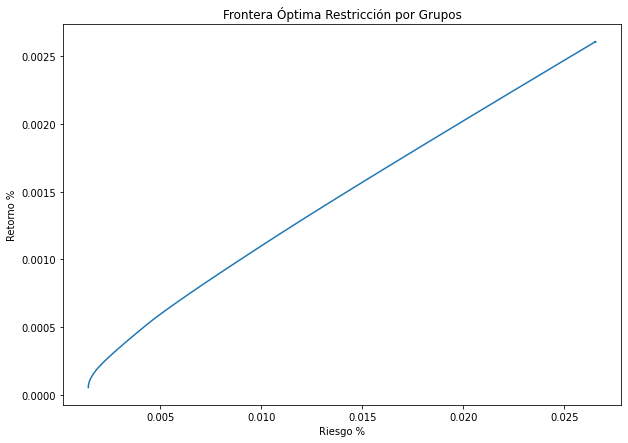

In [87]:
ax = rest_intervalo_grupos.plot.line(x="riesgo", y="retorno", title = "Frontera Óptima Restricción por Grupos", legend=False, figsize=(10,7))
ax.set_xlabel("Riesgo %")
ax.set_ylabel("Retorno %")

In [88]:
np.round(portfolios[0], decimals = 3)

array([[0.5],
       [0. ],
       [0. ],
       [0.3]])

In [89]:
rest_intervalo_grupos.iloc[0]

riesgo     0.026543
retorno    0.002608
phi        0.100000
Name: 0, dtype: float64

In [90]:
g@ np.array(portfolios[0]) 

array([0.00260839])

In [91]:
rest_intervalo_grupos.iloc[-1]

riesgo        0.001428
retorno       0.000053
phi        8912.509381
Name: 99, dtype: float64

In [92]:
np.round(portfolios[-1], decimals = 3)

array([[0.004],
       [0.061],
       [0.196],
       [0.039]])

In [93]:
g@ np.array(portfolios[-1]) 

array([5.27324187e-05])

# Restricción de cardinalidad o número de activos

In [94]:
combinaciones = list(itertools.combinations([0,1,2,3], r = 3))

In [95]:
list(combinaciones[1])

[0, 1, 3]

In [96]:
(retpor.iloc[:,list(combinaciones[1])]).cov()

,BTC-USD,GC=F,^MXX
BTC-USD,0.002706,-0.000033,0.000070
GC=F,-0.000033,0.000091,0.000002
^MXX,0.000070,0.000002,0.000078


In [97]:
print(matrix(np.matrix((retpor.iloc[:,list(combinaciones[1])]).cov())))

[ 2.71e-03 -3.25e-05  7.00e-05]
[-3.25e-05  9.13e-05  2.30e-06]
[ 7.00e-05  2.30e-06  7.79e-05]



In [99]:
riesgos_todos = []
retornos_todos = []
for combinacion in combinaciones:
  # cálculo de parámetros
  datos_combinacion = retpor.iloc[:,list(combinacion)]
  S = matrix(np.matrix((retpor.iloc[:,list(combinaciones[1])]).cov()))
  pbar = matrix(np.matrix((datos_combinacion).mean()).T)
  # 
  n = len(pbar)


  # Restriccioń de no ventas en corto
  # G es la matriz identidad y tiene que ver con la restricción x >= 0 (parte derecha G x)
  G = matrix(0.0, (n,n))
  G[::n+1] = -1.0
  # h es un vector de ceros y es el lado derecho de la restriccioń x >= 0
  h = matrix(0.0, (n,1))

  ## Restriccioń de alocacioń de todo el capital
  # Esta matriz tiene que ver con la rstricción 1T x = 1 y es una matriz (o mas bien vector) de 1 (parte izq)
  A = matrix(1.0, (1,n))
  # es escalar 1 que es la parte derecha de 1T x = 1
  b = matrix(1.0)

  # Definición de número de valores de phi que se van a calcular.
  N = 100
  phis = [ 10**(5.0*t/N-1.0) for t in range(N) ]
  portfolios = [ qp(phi*S, -pbar, G, h, A, b)['x'] for phi in phis ]


  returns = [ dot(pbar,x) for x in portfolios ]
  retornos_todos.append(returns)
  risks = [ sqrt(dot(x, S*x)) for x in portfolios ]
  riesgos_todos.append(risks)
  




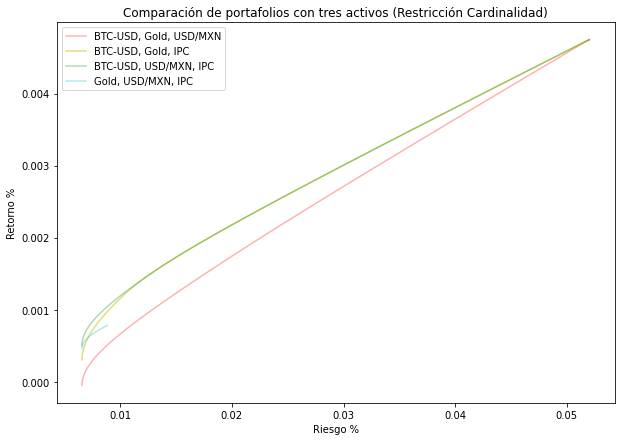

In [100]:
figure(figsize=(10, 7))
plt.plot(riesgos_todos[0], retornos_todos[0], alpha = 0.3, color = "r", label ="BTC-USD, Gold, USD/MXN")
plt.plot(riesgos_todos[1], retornos_todos[1], alpha = 0.5, color = "y", label ="BTC-USD, Gold, IPC")
plt.plot(riesgos_todos[2], retornos_todos[2], alpha = 0.3, color = "g", label ="BTC-USD, USD/MXN, IPC")
plt.plot(riesgos_todos[3], retornos_todos[3], alpha = 0.3, color ="c", label ="Gold, USD/MXN, IPC")
plt.legend()
plt.title("Comparación de portafolios con tres activos (Restricción Cardinalidad)")
plt.xlabel("Riesgo %")
plt.ylabel("Retorno %")

plt.show()

Notar que en la gráfica de arriba, el portafolio  verde es el óptimo con respecto a los demás para todos los niveles de riesgo (aunque para riesgos altos, se obtienen casi los mismos rendimientos esperados)

In [101]:
np.max(riesgos_todos[3])

0.008825171935245705

In [102]:
np.max(retornos_todos[3])

0.0007790742397789788